# Semester 3 Coding Portfolio Topic 5 Summative:
# Social Network Analysis

In [ ]:
# TODO: Please enter your student number here
STUDENT_NUMBER = ...

sources/useful links:
https://theepsteinlist.com/
https://www.wired.com/story/jeffrey-epstein-island-visitors-data-broker-leak/
https://www.businessinsider.com/every-flight-made-by-jeffrey-epsteins-private-jets-2020-7
https://www.documentcloud.org/documents/21165424-epstein-flight-logs-released-in-usa-vs-maxwell/?utm_source=chatgpt.com

<table>
<tr>
<td style="vertical-align: top; padding-right: 25px;">

<h2><b>BACKSTORY</b></h2>

<p>
Jeffrey Edward Epstein (January 20, 1953 – August 10, 2019) was an American financier and child sex offender. 
He began his professional career as a teacher at the Dalton School. After his dismissal from the school in 1976, 
he entered the banking and finance sector, working at Bear Stearns in various roles before starting his own firm. 
Epstein cultivated an elite social circle and procured many women and girls whom he and his associates sexually abused.
</p>

<p>
Epstein was notorious for maintaining his "elite" connections. Through his friendship with Ghislaine Maxwell he was able 
to befriend the highest classes and most powerful people of the world. He was known for his friendship with Andrew Mountbatten 
(former prince) and Donald Trump (former U.S. president).
</p>

<p>
My interest in looking at Epstein's network was sparked by reading Virginia Giuffre's memoir, 
<i>"Nobody's Girl: A Memoir of Surviving Abuse and Fighting for Justice"</i>. 
Giuffre was one of Epstein's most public victims; tragically, she took her own life in 2025.
</p>

<p>
The fight for sex-trafficking victims continues, and my analysis can be one small part 
of the collective effort to bring liable offenders to justice.
</p>

<p>
Information was taken from Wikipedia.com
</p>

</td>

<td style="vertical-align: top;">

<img src="epstein1.png" width="600">
<img src="epstein2.png" width="600">
<img src="epstein3.png" width="600">

</td>
</tr>
</table>


**(0) imports all!**

In [ ]:
import json
import csv
from collections import Counter
from itertools import combinations


import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt

**(1) Converting source txt into jsonl**

In [ ]:
with open("epstein_emails_insights_all.txt", encoding="utf-8") as file:
    data = json.load(file)

print(f"Loaded {len(data)} email records.")

with open("epstein_emails.jsonl", "w", encoding="utf-8") as out:
    for record in data:
        out.write(json.dumps(record, ensure_ascii=False) + "\n")

print("Wrote JSONL to epstein_emails.jsonl")

Loaded 2322 email records.
Wrote JSONL to epstein_emails.jsonl


**(2) Load jsonl into python and Inspect Structure**

In [65]:
emails = []
with open("epstein_emails.jsonl", encoding="utf-8") as f:
    for line in f:
        emails.append(json.loads(line))


print(f"Total emails loaded: {len(emails)}")
print("Keys in first email:", emails[0].keys())


Total emails loaded: 2322
Keys in first email: dict_keys(['source_file', 'subject', 'date', 'participants', 'people_mentioned', 'notable_figures', 'organizations', 'locations', 'summary', 'primary_topic', 'topics', 'tone', 'potential_crimes', 'crime_types', 'mentions_victims', 'victim_names', 'cover_up', 'email_text'])


**(3) Extract Participants & Build Pair Co-occurrence**

In [66]:
pair_counter = Counter()
appearances_counter = Counter()


for record in emails:
    participants = record.get("participants", [])
    participants = sorted(set(participants))


    for p in participants:
        appearances_counter[p] += 1


    if len(participants) >= 2:
        for a, b in combinations(participants, 2):
            pair_counter[(a, b)] += 1


print("Unique participants:", len(appearances_counter))


Unique participants: 1119


**(4) Relevant for future analysis: Extract Mentioned Entities (People/Orgs/Locations)**

In [4]:
all_people_mentioned = set()
all_notable_figures = set()
all_organizations = set()
all_locations = set()

for record in emails:
    for name in record.get("people_mentioned") or []:
        all_people_mentioned.add(name.strip())
    for name in record.get("notable_figures") or []:
        all_notable_figures.add(name.strip())
    for org in record.get("organizations") or []:
        all_organizations.add(org.strip())
    for loc in record.get("locations") or []:
        all_locations.add(loc.strip())

print("Unique people_mentioned:", len(all_people_mentioned))
print("Unique notable_figures:", len(all_notable_figures))
print("Unique organizations:", len(all_organizations))
print("Unique locations:", len(all_locations))

#sample outputs
print("\nSample notable_figures:", sorted(list(all_notable_figures))[:30])


Unique people_mentioned: 4509
Unique notable_figures: 1530
Unique organizations: 3275
Unique locations: 1512

Sample notable_figures: ['Aaron Sorkin', 'Abba Eban', 'Abbie Hoffman', 'Abdoulaye Wade', 'Abdul Fattah al-Sisi', 'Abdul Kalam', 'Abdullah', 'Abdulmalik Al-Makhlafi', 'Abraham Lincoln', 'Ace Greenberg', 'Acosta', 'Adam Friedman', 'Adam Lindemann', 'Adam Neumann', 'Adam Norbury', 'Adam Sandler', 'Adam Serwer', 'Adele', 'Adlai Stevenson', 'Adolf Hitler', 'Adolphus Busch', 'Adrien Brody', 'Ahmad Fatfat', 'Ahmed Yassin', 'Ahmed abu Rishaann', 'Ahmet Davutoglu', 'Al Franken', 'Al Gore', 'Al Sharpton', 'Al Waleed']


In [ ]:
def write_list_to_csv(values, path, header_name):
    values = sorted(v for v in values if v)  # drop empty strings
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([header_name])
        for v in values:
            writer.writerow([v])

write_list_to_csv(all_people_mentioned,   "people_mentioned.csv",   "person")
write_list_to_csv(all_notable_figures,    "notable_figures.csv",    "notable_figure")
write_list_to_csv(all_organizations,      "organizations.csv",      "organization")
write_list_to_csv(all_locations,          "locations.csv",          "location")


In [6]:
with open("participant_pairs.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["person_a", "person_b", "weight"])
    for (a, b), w in pair_counter.items():
        writer.writerow([a, b, w])


**(5) Build NetworkX graph**

In [ ]:
G = nx.Graph()

#edges with weight
for (a, b), w in pair_counter.items():
    G.add_edge(a, b, weight=w)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 1114
Number of edges: 7544


**(5.1) Community detection**

In [ ]:
communities = greedy_modularity_communities(G)
print("Number of communities found:", len(communities))
community_dict = {}
for cid, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = cid
        # criteria for comm? 

Number of communities found: 33


**(6) NETWORKX ANALYSIS**

**(6.1) **

In [ ]:
#degree (connections count)
degree_dict = dict(G.degree())

#degree centrality 
deg_centrality = nx.degree_centrality(G)

#betweenness centrality
bet_centrality = nx.betweenness_centrality(G, normalized=True)


**(6.2) NODES**

In [ ]:
node_rows = []

for node in G.nodes():
    row = {
        "id": node,
        "label": node,
        "degree": degree_dict.get(node, 0),
        "degree_centrality": deg_centrality.get(node, 0.0),
        "betweenness_centrality": bet_centrality.get(node, 0.0),
        "community": community_dict.get(node, -1),
    }
    node_rows.append(row)

nodes_df = pd.DataFrame(node_rows)

print(nodes_df.head())


              id          label  degree  degree_centrality  \
0      John Page      John Page      10           0.008985   
1    Kirk Blouin    Kirk Blouin      10           0.008985   
2      Mr. Fried      Mr. Fried      10           0.008985   
3   Mr. Randolph   Mr. Randolph      10           0.008985   
4  Ms. Van Buren  Ms. Van Buren      10           0.008985   

   betweenness_centrality  community  
0            4.039895e-07         14  
1            4.039895e-07         14  
2            4.039895e-07         14  
3            4.039895e-07         14  
4            4.039895e-07         14  


**(6.3) EDGES**

In [12]:
edge_rows = []

for u, v, data in G.edges(data=True):
    row = {
        "source": u,
        "target": v,
        "weight": data.get("weight", 1),
    }
    edge_rows.append(row)

edges_df = pd.DataFrame(edge_rows)

print(edges_df.head())


      source         target  weight
0  John Page    Kirk Blouin       2
1  John Page      Mr. Fried       2
2  John Page   Mr. Randolph       2
3  John Page  Ms. Van Buren       2
4  John Page      Ray Royce       2


**(6.4) Save nodes csv and edges csv to plug it into gephi later**

In [13]:
nodes_df.to_csv("epstein_nodes.csv", index=False)
edges_df.to_csv("epstein_edges.csv", index=False)

print("Saved epstein_nodes.csv and epstein_edges.csv")


Saved epstein_nodes.csv and epstein_edges.csv


**(6.5) Desiplay top 20 nodes with all factors**

In [70]:
from IPython.display import display


def show_top(df, col, n=20):
    return df.sort_values(col, ascending=False).head(n)


print("Top 20 for analysis:")
display(show_top(full_nodes, "betweenness_centrality"))

Top 20 for analysis:


,id,degree,degree_centrality,betweenness_centrality,eigenvector_centrality,closeness_centrality,label,community
14,Jeffrey Epstein,991,0.890386,0.893168,0.521770,0.893816,Jeffrey Epstein,21
767,Paul Krassner,30,0.026954,0.026033,0.017414,0.480752,Paul Krassner,25
776,paul krassner,32,0.028751,0.019894,0.016887,0.480533,paul krassner,25
28,Darren Indyke,121,0.108715,0.010557,0.084549,0.496845,Darren Indyke,5
578,Tom,45,0.040431,0.008581,0.040116,0.483398,Tom,20
772,Nancy Cain,21,0.018868,0.007806,0.017041,0.478786,Nancy Cain,25
370,Kathy Ruemmler,125,0.112309,0.007471,0.092375,0.498726,Kathy Ruemmler,21
48,Alan Dershowitz,110,0.098832,0.006967,0.094093,0.499672,Alan Dershowitz,4
319,Terry Kafka,60,0.053908,0.005978,0.074712,0.482292,Terry Kafka,10
311,Janet Kafka,60,0.053908,0.005968,0.075111,0.482292,Janet Kafka,10


**(7) Python visualisation to cross check with gephi**

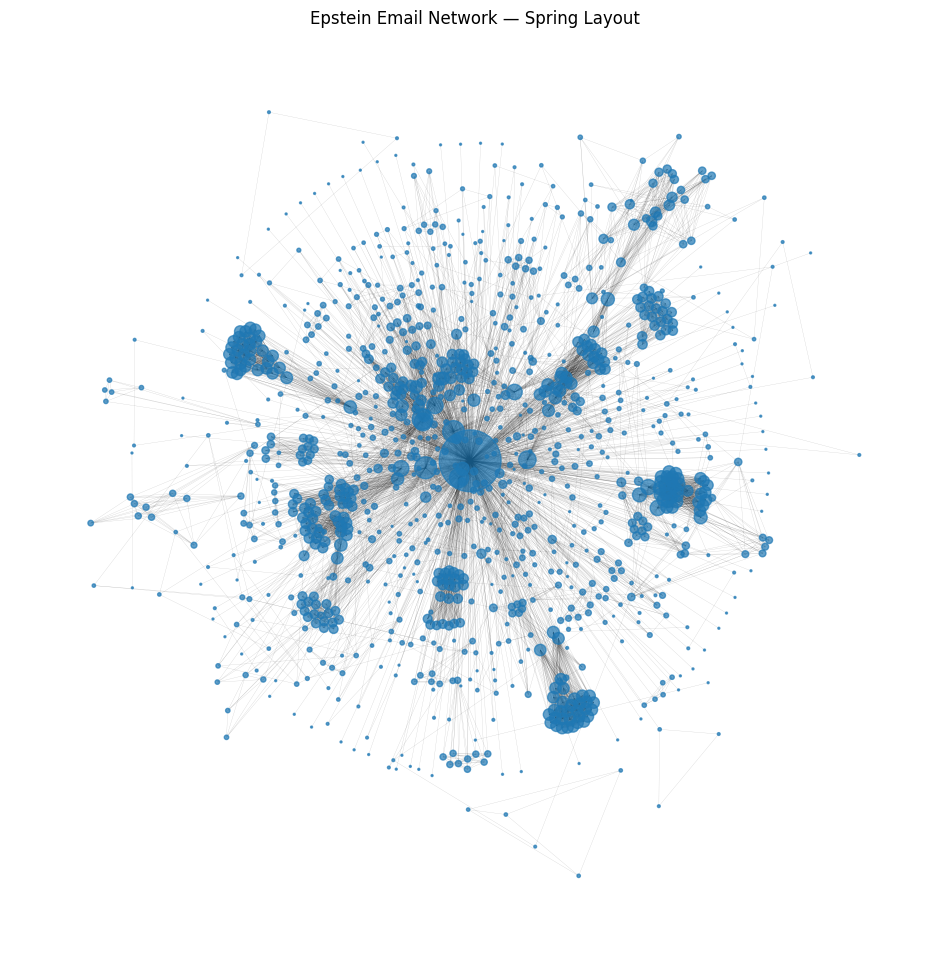

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=30)
degrees = dict(G.degree())
sizes = [degrees[n] * 2 for n in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.2)
plt.axis("off")
plt.title("Epstein Email Network")
plt.show()

**ADDITIONAL: for future development**

In [72]:
N = 100
top_deg = full_nodes.nlargest(N, "degree_centrality")["id"]
top_bet = full_nodes.nlargest(N, "betweenness_centrality")["id"]
focus_ids = pd.unique(pd.concat([top_deg, top_bet]))


H = G.subgraph(focus_ids).copy()
print("Focused subgraph:", H.number_of_nodes(), "nodes", H.number_of_edges(), "edges")
focus_nodes = full_nodes[full_nodes["id"].isin(focus_ids)]
focus_edges = nx.to_pandas_edgelist(H)


focus_nodes.to_csv("epstein_focus_nodes.csv", index=False)
focus_edges.to_csv("epstein_focus_edges.csv", index=False)

Focused subgraph: 162 nodes 1714 edges


In [73]:
full_nodes_with_meta = full_nodes.copy()
full_nodes_with_meta["sector"] = "unknown"
full_nodes_with_meta["role"] = "unknown"
full_nodes_with_meta["is_notable"] = 0


full_nodes_with_meta.to_csv("epstein_nodes_with_centralities_and_meta.csv", index=False)

notes: - important ppl not in the emails -> name recognition 
spaces between cluster -> structural holes (gain advantage): READ ACAD lit!!
- check out for victims (which email mentions and which people are mentioned in that email)
topic of the email (multivocality)
temporal networks (how it develops over time)
what were the criteria for the data to released (aka how full)
- check for thicker edges (pairing co occurance)
- just sender/recepient check out 


- papers about enron scandal -> elites enagagement email communication 


- tie as an edge attribute as potential elite activity (cluster on taht)